# Explore Price Correlations & Clusters

This notebook helps you explore the output from `compute_price_correlations.py`:
- **Clusters**: Groups of items whose prices move together
- **Pairs**: Individual item pairs with high correlation
- **Visualizations**: Time series plots to verify correlations

---

### 🚀 Run the Correlation Script First

```bash
# Quick test with 100 random items (~15 seconds)
uv run python scripts/compute_price_correlations.py --temporal-only --sample-items 100 --threshold 0.5 --verbose

# Medium test with 500 random items (~1-2 minutes)
uv run python scripts/compute_price_correlations.py --temporal-only --sample-items 500 --threshold 0.5 --verbose

# Larger test with 1000 random items (~3-5 minutes)
uv run python scripts/compute_price_correlations.py --temporal-only --sample-items 1000 --threshold 0.5 --verbose

# Full run with all 28k items (takes hours)
uv run python scripts/compute_price_correlations.py --temporal-only --threshold 0.5
```

**Options:**
- `--sample-items N` - Randomly sample N items
- `--max-items N` - Use first N items (sequential)
- `--threshold 0.5` - Correlation threshold (0.5 = moderate, 0.7 = strong)
- `--seed 42` - Random seed for reproducibility

---

### 📊 How the Clustering Works

The script finds groups of items whose prices **move together over time**. Here's the process:

#### Step 1: Build a Time-Aligned Price Matrix
For each item, resample the price data to hourly intervals and compute the average price per hour. This creates a matrix where rows are items and columns are time points.

#### Step 2: Compute Pairwise Correlations
For every pair of items (A, B), compute the **Pearson correlation** of their price time series:
- **+1.0** = Prices move perfectly together (when A goes up, B goes up)
- **-1.0** = Prices move perfectly opposite (when A goes up, B goes down)
- **0.0** = No relationship

#### Step 3: Build a Graph of Correlations
Create a graph where:
- Each **item is a node**
- An **edge connects two items** if their `|correlation| >= threshold`

```
Example with threshold=0.5:
   
   Item A ←--0.8--→ Item B ←--0.6--→ Item C
                         ↑
                        0.7
                         ↓
                      Item D
                      
Items A, B, C, D form one cluster (all connected)
```

#### Step 4: Find Connected Components
A **cluster** is a set of items that are all reachable from each other through correlation edges.

**Key insight:** Items don't need to ALL correlate with each other directly. If A↔B and B↔C correlate, then A, B, C are in the same cluster even if A↔C don't correlate directly. They're connected through B.

#### What the Threshold Means
| Threshold | Meaning | Result |
|-----------|---------|--------|
| `0.7` | Only strong correlations | Smaller, tighter clusters |
| `0.5` | Moderate correlations | Larger, looser clusters |
| `0.3` | Weak correlations | Very large clusters, may merge unrelated items |

---


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

try:
    import networkx as nx
    HAS_NETWORKX = True
except ImportError:
    HAS_NETWORKX = False
    print("⚠️ networkx not installed. Run: pip install networkx")

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Path to the snapshot directory (adjust if needed)
SNAPSHOT_DIR = Path("../data/cache/prices_snapshot_20251219_132555_tradable")

print(f"Snapshot directory: {SNAPSHOT_DIR}")
print(f"Exists: {SNAPSHOT_DIR.exists()}")


Snapshot directory: ../data/cache/prices_snapshot_20251219_132555_tradable
Exists: True


## 1. Load Cluster & Pair Data


In [21]:
# Load temporal clusters
clusters_path = SNAPSHOT_DIR / "clusters_temporal.csv"
if clusters_path.exists():
    clusters_df = pd.read_csv(clusters_path)
    print(f"Loaded {len(clusters_df)} items in clusters")
    display(clusters_df.head(10))
else:
    print(f"⚠️ Run the correlation script first:")
    print(f"   uv run python scripts/compute_price_correlations.py --temporal-only --sample-items 500")
    clusters_df = pd.DataFrame()


Loaded 500 items in clusters


item_id  cluster_id  cluster_size
0   100063           0           432
1   100244           0           432
2    10039           0           432
3   100739           0           432
4   100839           0           432
5     1009           0           432
6    10103           0           432
7    10113           0           432
8    10137           0           432
9    10192           0           432

In [22]:
# Load top pairs
pairs_path = SNAPSHOT_DIR / "top_pairs_temporal.csv"
if pairs_path.exists():
    pairs_df = pd.read_csv(pairs_path)
    print(f"Loaded {len(pairs_df)} correlated pairs")
    display(pairs_df.head(10))
else:
    pairs_df = pd.DataFrame()


Loaded 12148 correlated pairs


item_a  item_b      corr  pair_count  abs_corr
0  105262   14799 -1.353527         627  1.353527
1  105262   10947 -1.298476         627  1.298476
2  105262   11646  1.122126         627  1.122126
3  105262   77518 -1.080711         627  1.080711
4  105262    5098 -1.040700         626  1.040700
5  105262   30961 -1.033031         627  1.033031
6    1698   27136  1.002059        3156  1.002059
7    1698   27947  1.001742        3157  1.001742
8    1243   27136  1.001265        3161  1.001265
9    1243   27947  1.000949        3162  1.000949

## 2. Cluster Overview


In [23]:
# Cluster size distribution
if not clusters_df.empty:
    cluster_stats = clusters_df.groupby("cluster_id").agg(
        size=("item_id", "count"),
        items=("item_id", list)
    ).sort_values("size", ascending=False).reset_index()
    
    # Filter out singletons
    multi_item_clusters = cluster_stats[cluster_stats["size"] > 1]
    singletons = cluster_stats[cluster_stats["size"] == 1]
    
    print(f"📊 Cluster Statistics:")
    print(f"   Total clusters: {len(cluster_stats)}")
    print(f"   Multi-item clusters (size > 1): {len(multi_item_clusters)}")
    print(f"   Singletons (uncorrelated items): {len(singletons)}")
    print(f"\n📈 Multi-item cluster sizes:")
    display(multi_item_clusters[["cluster_id", "size"]].head(20))


📊 Cluster Statistics:
   Total clusters: 67
   Multi-item clusters (size > 1): 3
   Singletons (uncorrelated items): 64

📈 Multi-item cluster sizes:


cluster_id  size
0           0   432
1          12     2
2          15     2

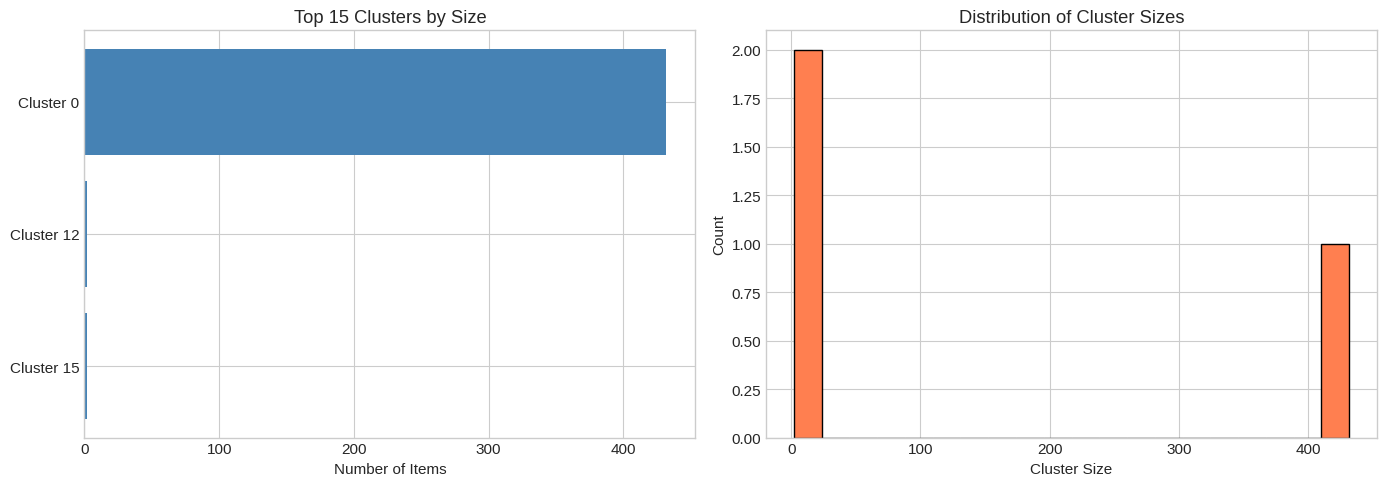

In [24]:
# Visualize cluster size distribution
if not clusters_df.empty and len(multi_item_clusters) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart of top clusters
    top_clusters = multi_item_clusters.head(15)
    axes[0].barh(
        [f"Cluster {c}" for c in top_clusters["cluster_id"]], 
        top_clusters["size"],
        color='steelblue'
    )
    axes[0].set_xlabel("Number of Items")
    axes[0].set_title("Top 15 Clusters by Size")
    axes[0].invert_yaxis()
    
    # Histogram of all cluster sizes
    axes[1].hist(multi_item_clusters["size"], bins=20, color='coral', edgecolor='black')
    axes[1].set_xlabel("Cluster Size")
    axes[1].set_ylabel("Count")
    axes[1].set_title("Distribution of Cluster Sizes")
    
    plt.tight_layout()
    plt.show()


## 3. Explore a Specific Cluster

Select a cluster to see its items and visualize their price movements together.


In [35]:
# ============================================
# 🎯 CHANGE THIS to explore different clusters
# ============================================
CLUSTER_ID = 12  # Try 0, 1, 2, etc.
MAX_ITEMS_TO_PLOT = 8  # Limit items shown in plot

# Get items in the selected cluster
if not clusters_df.empty:
    cluster_items = clusters_df[clusters_df["cluster_id"] == CLUSTER_ID]["item_id"].tolist()
    print(f"Cluster {CLUSTER_ID}: {len(cluster_items)} items")
    print(f"Items: {cluster_items[:20]}{'...' if len(cluster_items) > 20 else ''}")
else:
    cluster_items = []


Cluster 12: 2 items
Items: [14642, 14643]


In [36]:
def load_item_prices(item_id: int, snapshot_dir: Path, price_col: str = "sell_unit_price") -> pd.DataFrame:
    """Load price data for a single item."""
    item_path = snapshot_dir / f"item_{item_id}.csv"
    if not item_path.exists():
        return pd.DataFrame()
    
    df = pd.read_csv(item_path, usecols=["fetched_at", price_col])
    # Use ISO8601 format to handle mixed precision timestamps
    df["fetched_at"] = pd.to_datetime(df["fetched_at"], format="ISO8601")
    df = df.dropna()
    df = df.sort_values("fetched_at")
    return df.rename(columns={price_col: "price"})


def normalize_series(series: pd.Series) -> pd.Series:
    """Normalize to 0-1 range for comparison."""
    min_val, max_val = series.min(), series.max()
    if max_val == min_val:
        return series * 0 + 0.5
    return (series - min_val) / (max_val - min_val)


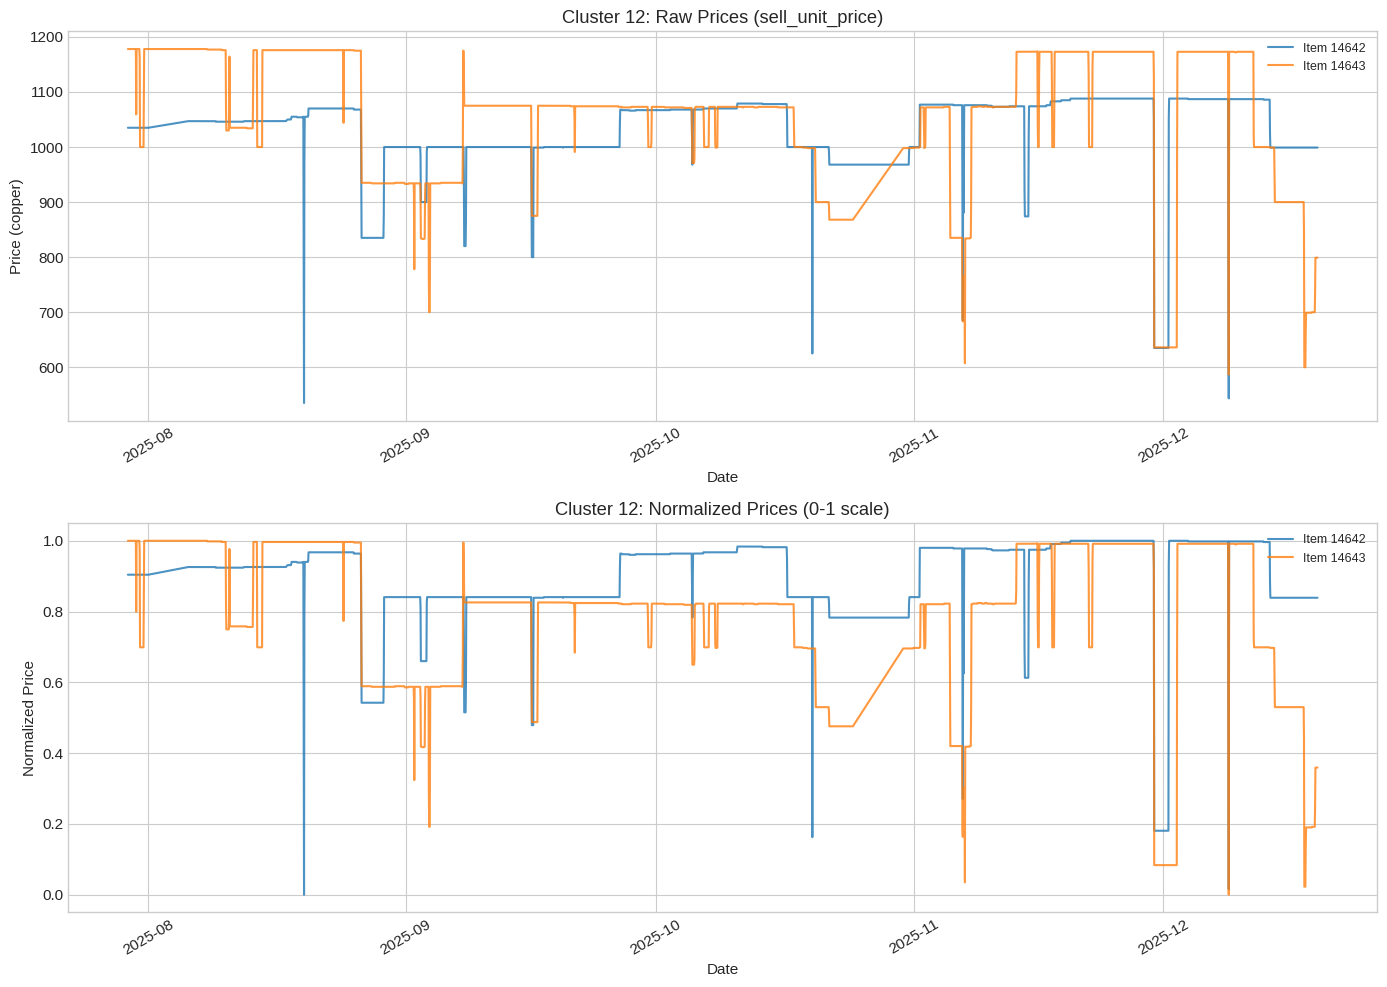


💡 The normalized plot shows if prices move together (correlation).
   Similar shapes = positive correlation, mirror images = negative correlation.


In [37]:
# Plot price time series for items in the cluster
if cluster_items:
    items_to_plot = cluster_items[:MAX_ITEMS_TO_PLOT]
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Raw prices
    for item_id in items_to_plot:
        df = load_item_prices(item_id, SNAPSHOT_DIR)
        if not df.empty:
            # Resample to hourly for cleaner plots
            df_hourly = df.set_index("fetched_at").resample("1h").mean().dropna()
            axes[0].plot(df_hourly.index, df_hourly["price"], label=f"Item {item_id}", alpha=0.8)
    
    axes[0].set_title(f"Cluster {CLUSTER_ID}: Raw Prices (sell_unit_price)")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Price (copper)")
    axes[0].legend(loc="upper right", fontsize=9)
    axes[0].tick_params(axis='x', rotation=30)
    
    # Plot 2: Normalized prices (0-1 scale) for easier comparison
    for item_id in items_to_plot:
        df = load_item_prices(item_id, SNAPSHOT_DIR)
        if not df.empty:
            df_hourly = df.set_index("fetched_at").resample("1h").mean().dropna()
            normalized = normalize_series(df_hourly["price"])
            axes[1].plot(df_hourly.index, normalized, label=f"Item {item_id}", alpha=0.8)
    
    axes[1].set_title(f"Cluster {CLUSTER_ID}: Normalized Prices (0-1 scale)")
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Normalized Price")
    axes[1].legend(loc="upper right", fontsize=9)
    axes[1].tick_params(axis='x', rotation=30)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n💡 The normalized plot shows if prices move together (correlation).")
    print(f"   Similar shapes = positive correlation, mirror images = negative correlation.")


## 4. Explore Top Correlated Pairs

Look at the most highly correlated item pairs.


In [38]:
# Top positive and negative correlations
if not pairs_df.empty:
    print("🔝 Top 10 Positive Correlations (prices move together):")
    display(pairs_df[pairs_df["corr"] > 0].head(10))
    
    print("\n🔄 Top 10 Negative Correlations (prices move opposite):")
    display(pairs_df[pairs_df["corr"] < 0].sort_values("corr").head(10))


🔝 Top 10 Positive Correlations (prices move together):


item_a  item_b      corr  pair_count  abs_corr
2   105262   11646  1.122126         627  1.122126
6     1698   27136  1.002059        3156  1.002059
7     1698   27947  1.001742        3157  1.001742
8     1243   27136  1.001265        3161  1.001265
9     1243   27947  1.000949        3162  1.000949
10    1243    1698  1.000791        3160  1.000791
11   27136   27947  1.000632        3163  1.000632
12    1698   37670  0.988738        3154  0.988738
13    1243   37670  0.987954        3159  0.987954
14   27947   37670  0.987329        3161  0.987329


🔄 Top 10 Negative Correlations (prices move opposite):


item_a  item_b      corr  pair_count  abs_corr
0    105262   14799 -1.353527         627  1.353527
1    105262   10947 -1.298476         627  1.298476
3    105262   77518 -1.080711         627  1.080711
4    105262    5098 -1.040700         626  1.040700
5    105262   30961 -1.033031         627  1.033031
30   105262    9973 -0.972290         627  0.972290
109    1039   41700 -0.946306        3157  0.946306
112  105262   32618 -0.945667         627  0.945667
129   74130   87358 -0.939682        3158  0.939682
130  105262   45989 -0.938646         627  0.938646

In [39]:
# ============================================
# 🎯 CHANGE THIS to explore a specific pair
# ============================================
ITEM_A = 10022  # First item ID
ITEM_B = 10031  # Second item ID

# Load and plot the pair
df_a = load_item_prices(ITEM_A, SNAPSHOT_DIR)
df_b = load_item_prices(ITEM_B, SNAPSHOT_DIR)

if not df_a.empty and not df_b.empty:
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    # Resample to hourly
    df_a_h = df_a.set_index("fetched_at").resample("1h").mean().dropna()
    df_b_h = df_b.set_index("fetched_at").resample("1h").mean().dropna()
    
    # Raw prices with dual y-axis
    ax1 = axes[0]
    ax2 = ax1.twinx()
    line1, = ax1.plot(df_a_h.index, df_a_h["price"], 'b-', label=f"Item {ITEM_A}", alpha=0.8)
    line2, = ax2.plot(df_b_h.index, df_b_h["price"], 'r-', label=f"Item {ITEM_B}", alpha=0.8)
    ax1.set_ylabel(f"Item {ITEM_A} Price", color='b')
    ax2.set_ylabel(f"Item {ITEM_B} Price", color='r')
    ax1.legend([line1, line2], [f"Item {ITEM_A}", f"Item {ITEM_B}"], loc="upper right")
    ax1.set_title(f"Pair: Item {ITEM_A} vs Item {ITEM_B} - Raw Prices")
    ax1.tick_params(axis='x', rotation=30)
    
    # Normalized overlay
    norm_a = normalize_series(df_a_h["price"])
    norm_b = normalize_series(df_b_h["price"])
    axes[1].plot(df_a_h.index, norm_a, 'b-', label=f"Item {ITEM_A}", alpha=0.8)
    axes[1].plot(df_b_h.index, norm_b, 'r-', label=f"Item {ITEM_B}", alpha=0.8)
    axes[1].set_title(f"Pair: Item {ITEM_A} vs Item {ITEM_B} - Normalized (0-1)")
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Normalized Price")
    axes[1].legend()
    axes[1].tick_params(axis='x', rotation=30)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate actual correlation
    merged = pd.merge(
        df_a_h.reset_index(), df_b_h.reset_index(), 
        on="fetched_at", suffixes=("_a", "_b")
    )
    if len(merged) > 2:
        actual_corr = merged["price_a"].corr(merged["price_b"])
        print(f"\n📊 Calculated correlation: {actual_corr:.4f}")
else:
    print(f"⚠️ Could not load data for items {ITEM_A} and/or {ITEM_B}")



📊 Calculated correlation: 0.9963


## 5. Correlation Heatmap for a Cluster

Visualize how all items in a cluster correlate with each other.


Building correlation matrix for 2 items from cluster 12...


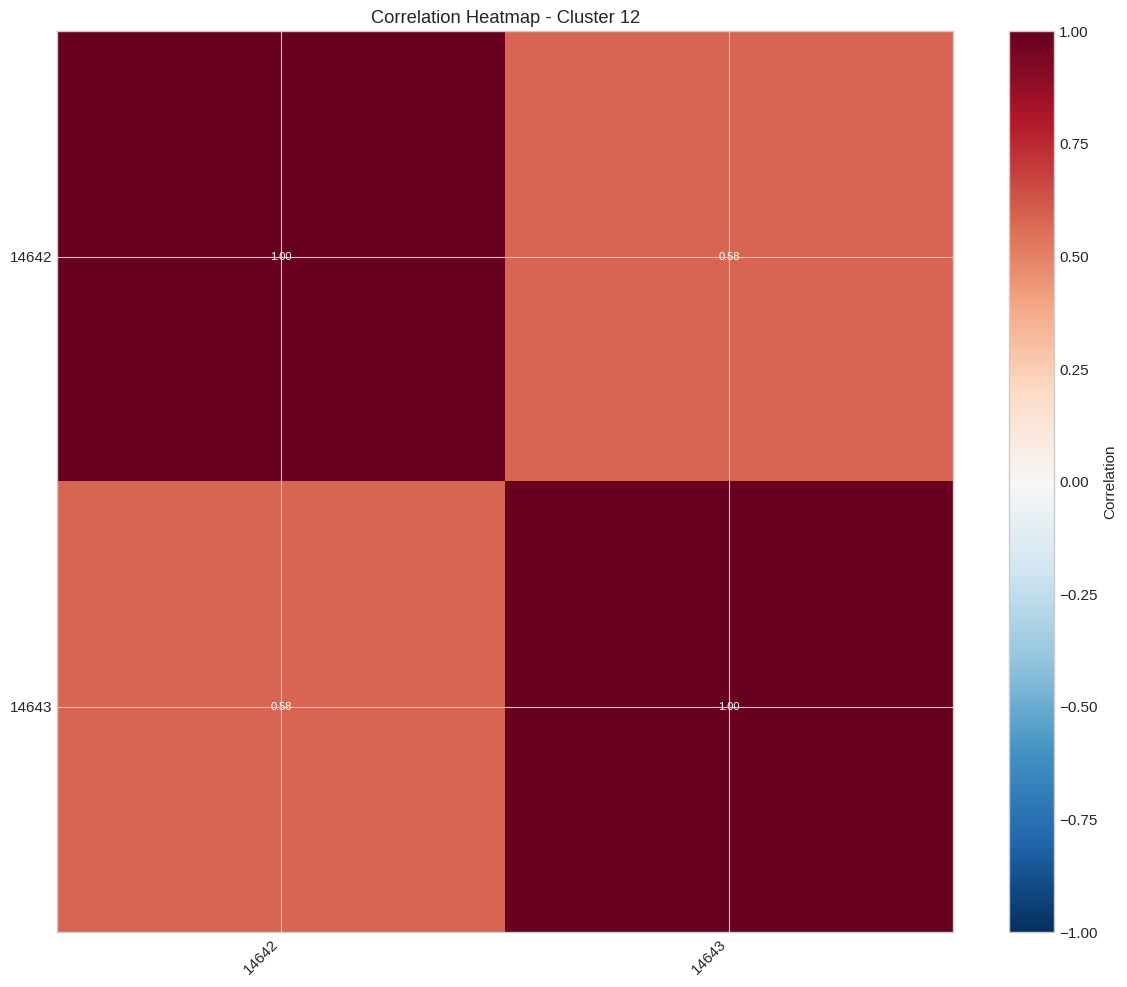


💡 Red = positive correlation, Blue = negative correlation


In [41]:
# ============================================
# 🎯 CHANGE THIS to analyze a different cluster
# ============================================
HEATMAP_CLUSTER_ID = 12
MAX_ITEMS_FOR_HEATMAP = 15  # Limit for readability

if not clusters_df.empty:
    heatmap_items = clusters_df[clusters_df["cluster_id"] == HEATMAP_CLUSTER_ID]["item_id"].tolist()
    heatmap_items = heatmap_items[:MAX_ITEMS_FOR_HEATMAP]
    
    print(f"Building correlation matrix for {len(heatmap_items)} items from cluster {HEATMAP_CLUSTER_ID}...")
    
    # Load all item data and resample
    item_series = {}
    for item_id in heatmap_items:
        df = load_item_prices(item_id, SNAPSHOT_DIR)
        if not df.empty:
            df_h = df.set_index("fetched_at").resample("1h").mean().dropna()
            item_series[item_id] = df_h["price"]
    
    if len(item_series) >= 2:
        # Combine into a DataFrame
        combined = pd.DataFrame(item_series)
        
        # Calculate correlation matrix
        corr_matrix = combined.corr()
        
        # Plot heatmap
        fig, ax = plt.subplots(figsize=(12, 10))
        im = ax.imshow(corr_matrix.values, cmap="RdBu_r", vmin=-1, vmax=1, aspect="auto")
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label("Correlation")
        
        # Add labels
        ax.set_xticks(range(len(corr_matrix.columns)))
        ax.set_yticks(range(len(corr_matrix.columns)))
        ax.set_xticklabels(corr_matrix.columns, rotation=45, ha="right")
        ax.set_yticklabels(corr_matrix.columns)
        
        # Add correlation values as text
        for i in range(len(corr_matrix)):
            for j in range(len(corr_matrix)):
                val = corr_matrix.iloc[i, j]
                color = "white" if abs(val) > 0.5 else "black"
                ax.text(j, i, f"{val:.2f}", ha="center", va="center", color=color, fontsize=8)
        
        ax.set_title(f"Correlation Heatmap - Cluster {HEATMAP_CLUSTER_ID}")
        plt.tight_layout()
        plt.show()
        
        print(f"\n💡 Red = positive correlation, Blue = negative correlation")
    else:
        print(f"⚠️ Not enough items with data")


## 6. Cross-Cluster Comparison

Compare items from **different clusters** to see that they do NOT correlate with each other.


In [42]:
# ============================================
# 🎯 CHANGE THESE to compare different clusters
# ============================================
CLUSTER_A = 0  # First cluster
CLUSTER_B = 12  # Second cluster (different from A)
ITEMS_PER_CLUSTER = 3  # How many items to show from each

if not clusters_df.empty:
    # Get items from each cluster
    items_cluster_a = clusters_df[clusters_df["cluster_id"] == CLUSTER_A]["item_id"].tolist()[:ITEMS_PER_CLUSTER]
    items_cluster_b = clusters_df[clusters_df["cluster_id"] == CLUSTER_B]["item_id"].tolist()[:ITEMS_PER_CLUSTER]
    
    print(f"Cluster {CLUSTER_A} items: {items_cluster_a}")
    print(f"Cluster {CLUSTER_B} items: {items_cluster_b}")
    
    if items_cluster_a and items_cluster_b:
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        
        # Top-left: Cluster A items (normalized)
        for item_id in items_cluster_a:
            df = load_item_prices(item_id, SNAPSHOT_DIR)
            if not df.empty:
                df_h = df.set_index("fetched_at").resample("1h").mean().dropna()
                axes[0, 0].plot(df_h.index, normalize_series(df_h["price"]), label=f"Item {item_id}", alpha=0.8)
        axes[0, 0].set_title(f"Cluster {CLUSTER_A} Items (normalized)")
        axes[0, 0].legend()
        axes[0, 0].set_ylabel("Normalized Price")
        axes[0, 0].tick_params(axis='x', rotation=30)
        
        # Top-right: Cluster B items (normalized)
        for item_id in items_cluster_b:
            df = load_item_prices(item_id, SNAPSHOT_DIR)
            if not df.empty:
                df_h = df.set_index("fetched_at").resample("1h").mean().dropna()
                axes[0, 1].plot(df_h.index, normalize_series(df_h["price"]), label=f"Item {item_id}", alpha=0.8)
        axes[0, 1].set_title(f"Cluster {CLUSTER_B} Items (normalized)")
        axes[0, 1].legend()
        axes[0, 1].set_ylabel("Normalized Price")
        axes[0, 1].tick_params(axis='x', rotation=30)
        
        # Bottom: All items together for comparison
        colors_a = ['#1f77b4', '#2ca02c', '#17becf']  # Blues/greens for cluster A
        colors_b = ['#d62728', '#ff7f0e', '#9467bd']  # Reds/oranges for cluster B
        
        for i, item_id in enumerate(items_cluster_a):
            df = load_item_prices(item_id, SNAPSHOT_DIR)
            if not df.empty:
                df_h = df.set_index("fetched_at").resample("1h").mean().dropna()
                axes[1, 0].plot(df_h.index, normalize_series(df_h["price"]), 
                               color=colors_a[i % len(colors_a)], 
                               label=f"C{CLUSTER_A}: {item_id}", alpha=0.8, linewidth=2)
        
        for i, item_id in enumerate(items_cluster_b):
            df = load_item_prices(item_id, SNAPSHOT_DIR)
            if not df.empty:
                df_h = df.set_index("fetched_at").resample("1h").mean().dropna()
                axes[1, 0].plot(df_h.index, normalize_series(df_h["price"]), 
                               color=colors_b[i % len(colors_b)], 
                               label=f"C{CLUSTER_B}: {item_id}", alpha=0.8, linewidth=2, linestyle='--')
        
        axes[1, 0].set_title(f"Both Clusters Overlaid (solid=C{CLUSTER_A}, dashed=C{CLUSTER_B})")
        axes[1, 0].legend(loc="upper right", fontsize=9)
        axes[1, 0].set_ylabel("Normalized Price")
        axes[1, 0].set_xlabel("Date")
        axes[1, 0].tick_params(axis='x', rotation=30)
        
        # Bottom-right: Cross-cluster correlation matrix
        all_items = items_cluster_a + items_cluster_b
        item_series = {}
        for item_id in all_items:
            df = load_item_prices(item_id, SNAPSHOT_DIR)
            if not df.empty:
                df_h = df.set_index("fetched_at").resample("1h").mean().dropna()
                item_series[item_id] = df_h["price"]
        
        if len(item_series) >= 2:
            combined = pd.DataFrame(item_series)
            corr_matrix = combined.corr()
            
            im = axes[1, 1].imshow(corr_matrix.values, cmap="RdBu_r", vmin=-1, vmax=1)
            plt.colorbar(im, ax=axes[1, 1], label="Correlation")
            
            axes[1, 1].set_xticks(range(len(corr_matrix.columns)))
            axes[1, 1].set_yticks(range(len(corr_matrix.columns)))
            labels = [f"C{CLUSTER_A}:{x}" if x in items_cluster_a else f"C{CLUSTER_B}:{x}" 
                     for x in corr_matrix.columns]
            axes[1, 1].set_xticklabels(labels, rotation=45, ha="right", fontsize=9)
            axes[1, 1].set_yticklabels(labels, fontsize=9)
            
            # Add text
            for i in range(len(corr_matrix)):
                for j in range(len(corr_matrix)):
                    val = corr_matrix.iloc[i, j]
                    color = "white" if abs(val) > 0.5 else "black"
                    axes[1, 1].text(j, i, f"{val:.2f}", ha="center", va="center", 
                                   color=color, fontsize=9)
            
            axes[1, 1].set_title("Cross-Cluster Correlation Matrix")
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n💡 Notice:")
        print(f"   - Items within the SAME cluster (top-left/top-right) have similar shapes")
        print(f"   - Items from DIFFERENT clusters (bottom-left overlay) have different patterns")
        print(f"   - The heatmap shows HIGH correlation within clusters, LOW correlation across clusters")


Cluster 0 items: [100063, 100244, 10039]
Cluster 12 items: [14642, 14643]



💡 Notice:
   - Items within the SAME cluster (top-left/top-right) have similar shapes
   - Items from DIFFERENT clusters (bottom-left overlay) have different patterns
   - The heatmap shows HIGH correlation within clusters, LOW correlation across clusters


## 7. Correlation Network Graph

Visualize the correlation structure as a network graph where:
- **Nodes** = Items (colored by cluster)
- **Edges** = Correlations above threshold (thicker = stronger correlation)


Graph: 50 nodes, 1223 edges


/tmp/ipykernel_61615/2570240437.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_clusters))


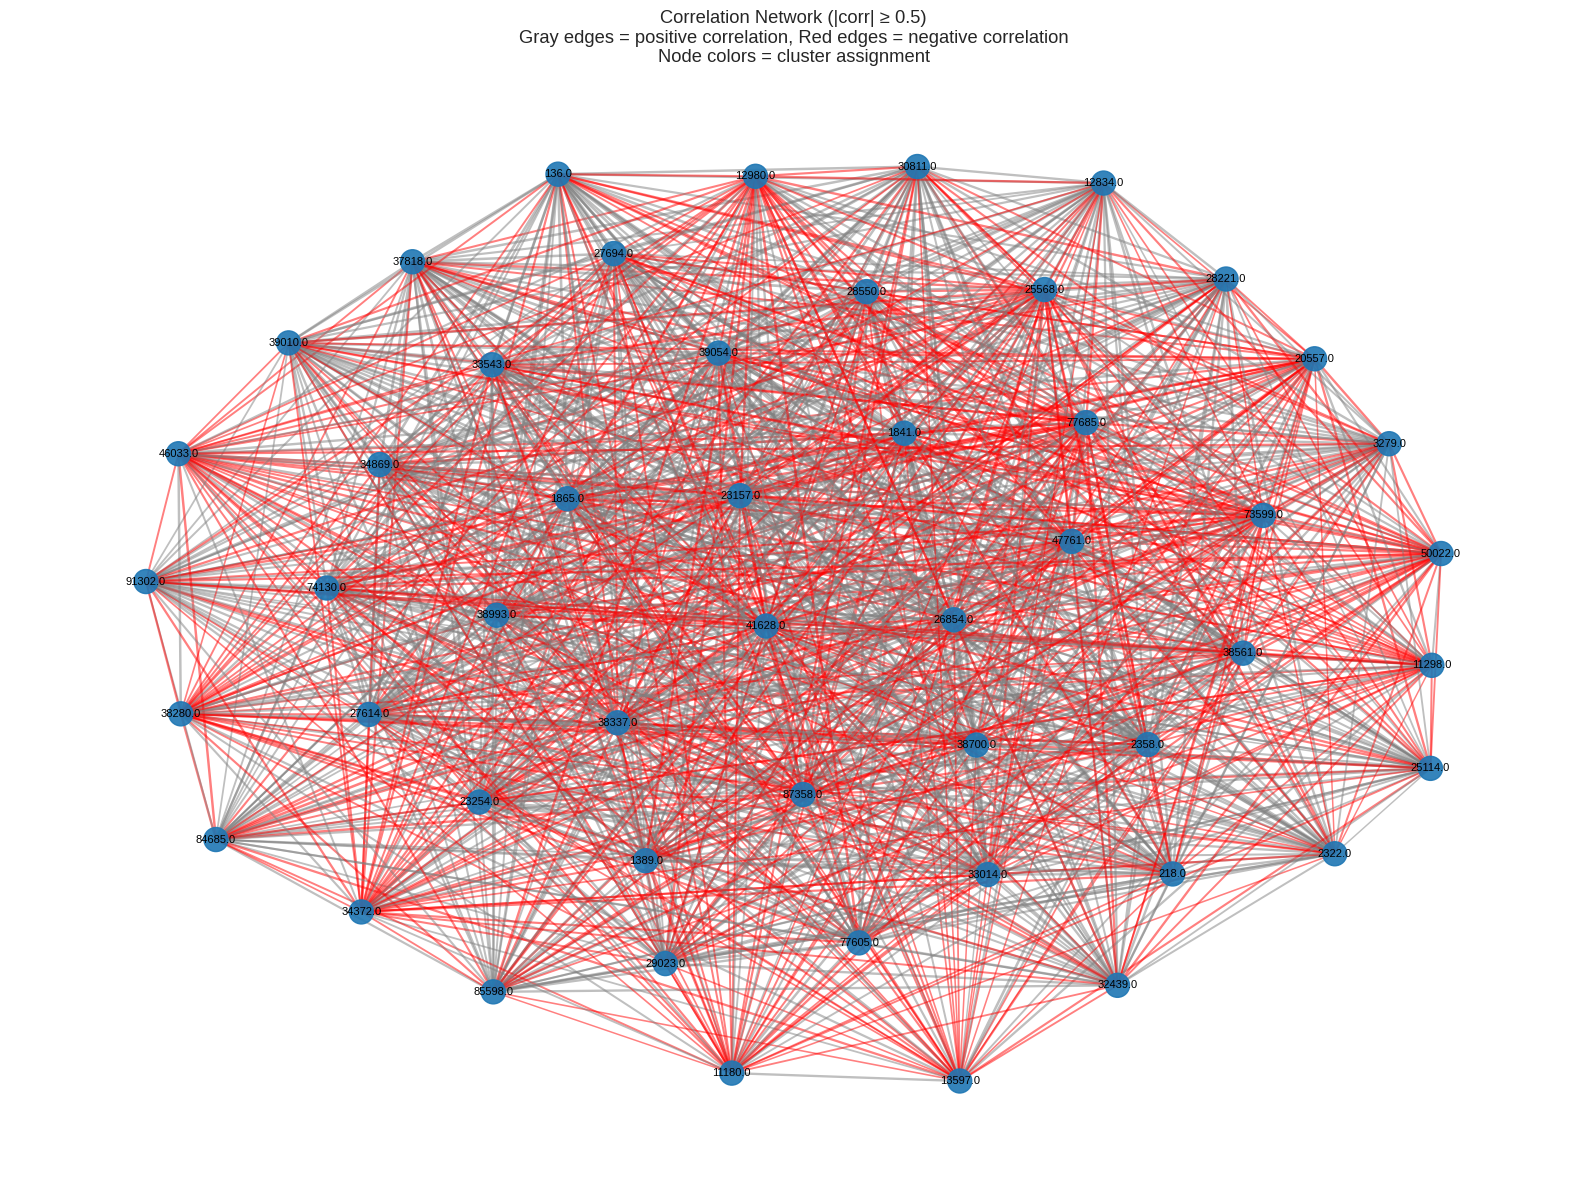


💡 Nodes that are close together are in the same cluster
   The spring layout pulls correlated items together


In [ ]:
# ============================================
# 🎯 CHANGE THESE to customize the graph
# ============================================
GRAPH_MIN_CORR = 0.5  # Only show edges with corr >= this
MAX_NODES = 50  # Limit nodes for readability (use None for all)
SHOW_EDGE_LABELS = False  # Show correlation values on edges
POSITIVE_ONLY = True  # Only show positive correlations

if HAS_NETWORKX and not pairs_df.empty and not clusters_df.empty:
    # Build the graph from pairs data
    G = nx.Graph()
    
    # Filter pairs by correlation threshold (positive only if requested)
    if POSITIVE_ONLY:
        filtered_pairs = pairs_df[(pairs_df["corr"] >= GRAPH_MIN_CORR)].copy()
    else:
        filtered_pairs = pairs_df[pairs_df["abs_corr"] >= GRAPH_MIN_CORR].copy()
    
    # Limit to top pairs if too many
    if MAX_NODES:
        # Get unique items from top pairs
        all_items = set(filtered_pairs["item_a"].tolist() + filtered_pairs["item_b"].tolist())
        if len(all_items) > MAX_NODES:
            # Take pairs involving the most connected items
            item_counts = pd.concat([filtered_pairs["item_a"], filtered_pairs["item_b"]]).value_counts()
            top_items = set(item_counts.head(MAX_NODES).index)
            filtered_pairs = filtered_pairs[
                filtered_pairs["item_a"].isin(top_items) & 
                filtered_pairs["item_b"].isin(top_items)
            ]
    
    # Add edges
    for _, row in filtered_pairs.iterrows():
        G.add_edge(row["item_a"], row["item_b"], weight=row["abs_corr"], corr=row["corr"])
    
    print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    
    if G.number_of_nodes() > 0:
        # Get cluster assignments for coloring
        item_to_cluster = dict(zip(clusters_df["item_id"], clusters_df["cluster_id"]))
        node_colors = [item_to_cluster.get(node, -1) for node in G.nodes()]
        
        # Create layout
        fig, ax = plt.subplots(figsize=(16, 12))
        
        # Use spring layout (force-directed) - connected nodes pull together
        pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
        
        # Draw edges (width based on correlation strength)
        edges = G.edges(data=True)
        edge_weights = [d["weight"] * 2 for _, _, d in edges]
        edge_colors = ["red" if d["corr"] < 0 else "gray" for _, _, d in edges]
        
        nx.draw_networkx_edges(G, pos, alpha=0.5, width=edge_weights, 
                               edge_color=edge_colors, ax=ax)
        
        # Draw nodes (color by cluster)
        unique_clusters = list(set(node_colors))
        cmap = plt.cm.get_cmap("tab20", len(unique_clusters))
        color_map = [cmap(unique_clusters.index(c)) for c in node_colors]
        
        nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=300, 
                               alpha=0.9, ax=ax)
        
        # Draw labels
        nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)
        
        # Draw edge labels if requested
        if SHOW_EDGE_LABELS:
            edge_labels = {(u, v): f"{d['corr']:.2f}" for u, v, d in edges}
            nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6, ax=ax)
        
        corr_type = "positive only" if POSITIVE_ONLY else "positive & negative"
        ax.set_title(f"Correlation Network (corr ≥ {GRAPH_MIN_CORR}, {corr_type})\n"
                    f"Gray edges = positive correlation, Red edges = negative correlation\n"
                    f"Node colors = cluster assignment")
        ax.axis("off")
        plt.tight_layout()
        plt.show()
        
        print(f"\n💡 Nodes that are close together are in the same cluster")
        print(f"   The spring layout pulls correlated items together")
else:
    if not HAS_NETWORKX:
        print("⚠️ Install networkx: pip install networkx")
    else:
        print("⚠️ No pairs or clusters data loaded")


Cluster 12 graph: 2 nodes, 1 edges


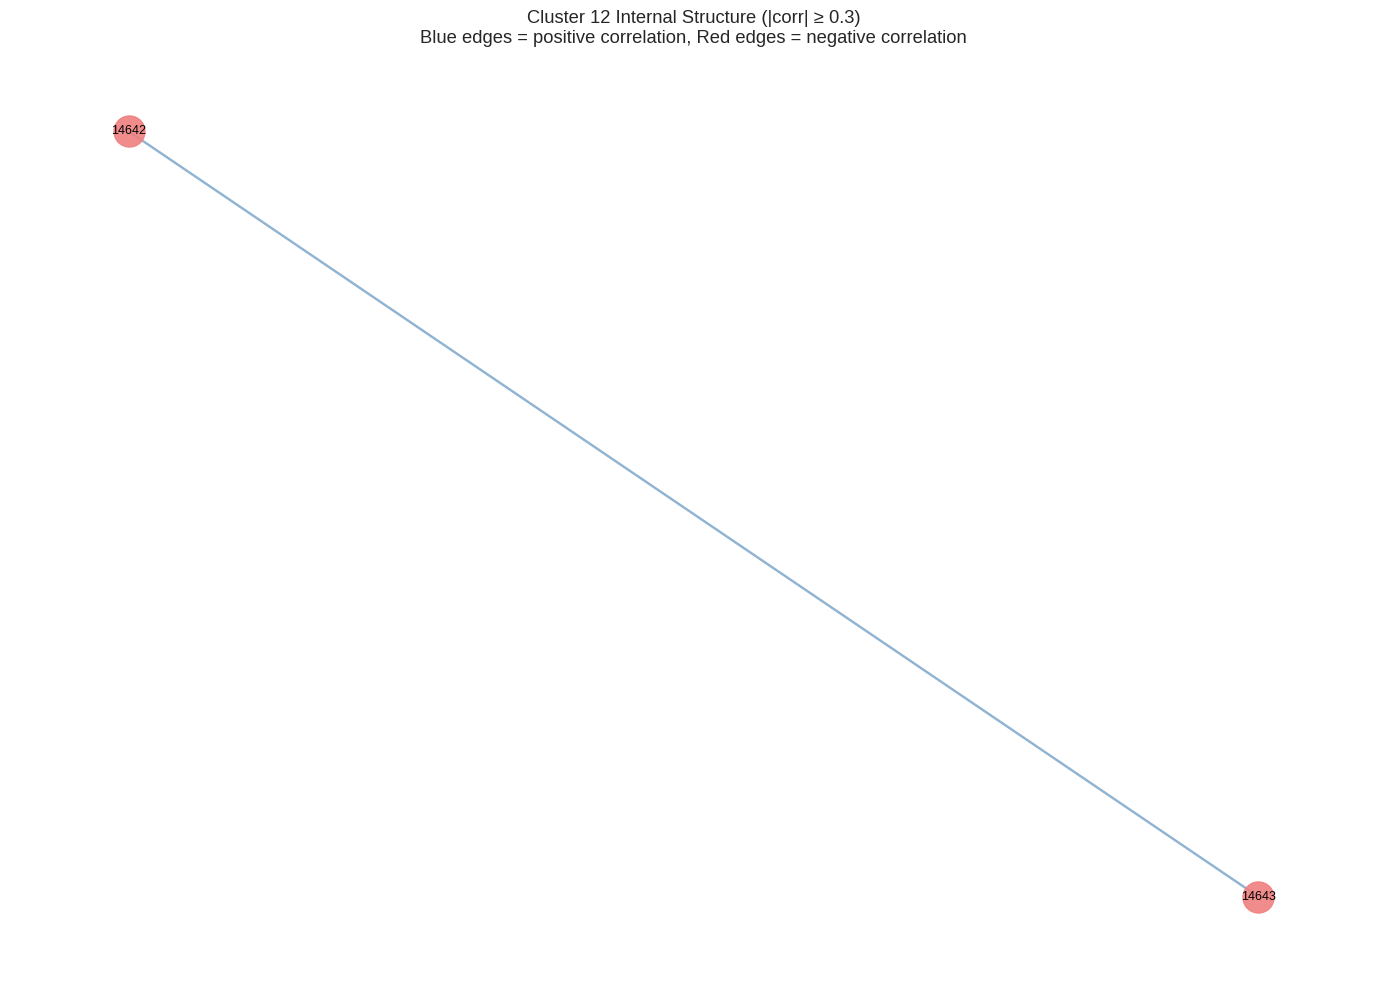


📊 Most connected items in cluster 12:
   Item 14642: 1 connections
   Item 14643: 1 connections


In [ ]:
# ============================================
# 🎯 Focus on a SINGLE CLUSTER's internal graph
# ============================================
FOCUS_CLUSTER = 0  # Which cluster to visualize
FOCUS_MIN_CORR = 0.3  # Lower threshold to see more internal connections
FOCUS_POSITIVE_ONLY = True  # Only show positive correlations

if HAS_NETWORKX and not pairs_df.empty and not clusters_df.empty:
    # Get items in this cluster
    cluster_items = set(clusters_df[clusters_df["cluster_id"] == FOCUS_CLUSTER]["item_id"].tolist())
    
    if len(cluster_items) < 2:
        print(f"⚠️ Cluster {FOCUS_CLUSTER} has fewer than 2 items")
    else:
        # Build graph for just this cluster
        G_cluster = nx.Graph()
        
        # Add all items as nodes first
        for item in cluster_items:
            G_cluster.add_node(item)
        
        # Filter pairs to only those within this cluster
        if FOCUS_POSITIVE_ONLY:
            cluster_pairs = pairs_df[
                (pairs_df["item_a"].isin(cluster_items)) & 
                (pairs_df["item_b"].isin(cluster_items)) &
                (pairs_df["corr"] >= FOCUS_MIN_CORR)
            ]
        else:
            cluster_pairs = pairs_df[
                (pairs_df["item_a"].isin(cluster_items)) & 
                (pairs_df["item_b"].isin(cluster_items)) &
                (pairs_df["abs_corr"] >= FOCUS_MIN_CORR)
            ]
        
        # Add edges
        for _, row in cluster_pairs.iterrows():
            G_cluster.add_edge(row["item_a"], row["item_b"], 
                              weight=row["abs_corr"], corr=row["corr"])
        
        print(f"Cluster {FOCUS_CLUSTER} graph: {G_cluster.number_of_nodes()} nodes, {G_cluster.number_of_edges()} edges")
        
        fig, ax = plt.subplots(figsize=(14, 10))
        
        # Layout
        if G_cluster.number_of_edges() > 0:
            pos = nx.spring_layout(G_cluster, k=1.5, iterations=50, seed=42)
        else:
            pos = nx.circular_layout(G_cluster)
        
        # Draw edges
        if G_cluster.number_of_edges() > 0:
            edges = G_cluster.edges(data=True)
            edge_weights = [d["weight"] * 3 for _, _, d in edges]
            edge_colors = ["red" if d["corr"] < 0 else "steelblue" for _, _, d in edges]
            nx.draw_networkx_edges(G_cluster, pos, alpha=0.6, width=edge_weights, 
                                   edge_color=edge_colors, ax=ax)
        
        # Draw nodes
        nx.draw_networkx_nodes(G_cluster, pos, node_color="lightcoral", 
                               node_size=500, alpha=0.9, ax=ax)
        nx.draw_networkx_labels(G_cluster, pos, font_size=9, ax=ax)
        
        corr_type = "positive only" if FOCUS_POSITIVE_ONLY else "positive & negative"
        ax.set_title(f"Cluster {FOCUS_CLUSTER} Internal Structure (corr ≥ {FOCUS_MIN_CORR}, {corr_type})\n"
                    f"Blue edges = positive correlation, Red edges = negative correlation")
        ax.axis("off")
        plt.tight_layout()
        plt.show()
        
        # Show some stats
        if G_cluster.number_of_edges() > 0:
            degrees = dict(G_cluster.degree())
            most_connected = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:5]
            print(f"\n📊 Most connected items in cluster {FOCUS_CLUSTER}:")
            for item, deg in most_connected:
                print(f"   Item {item}: {deg} connections")


### Ego Graph: Explore from a Single Item

Select one item and see its correlation neighborhood - items directly connected, and optionally their connections too.


Ego graph for item 69665:
   157 nodes, 2966 edges
   Layers: 2, Min correlation: 0.5


/tmp/ipykernel_61615/1329940586.py:110: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_61615/1329940586.py:110: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_61615/1329940586.py:110: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/home/daniel/dev/ai/casml4se-stonkswagen/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/daniel/dev/ai/casml4se-stonkswagen/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/daniel/dev/ai/casml4se-stonkswagen/.venv/lib/python3.12/site-packages

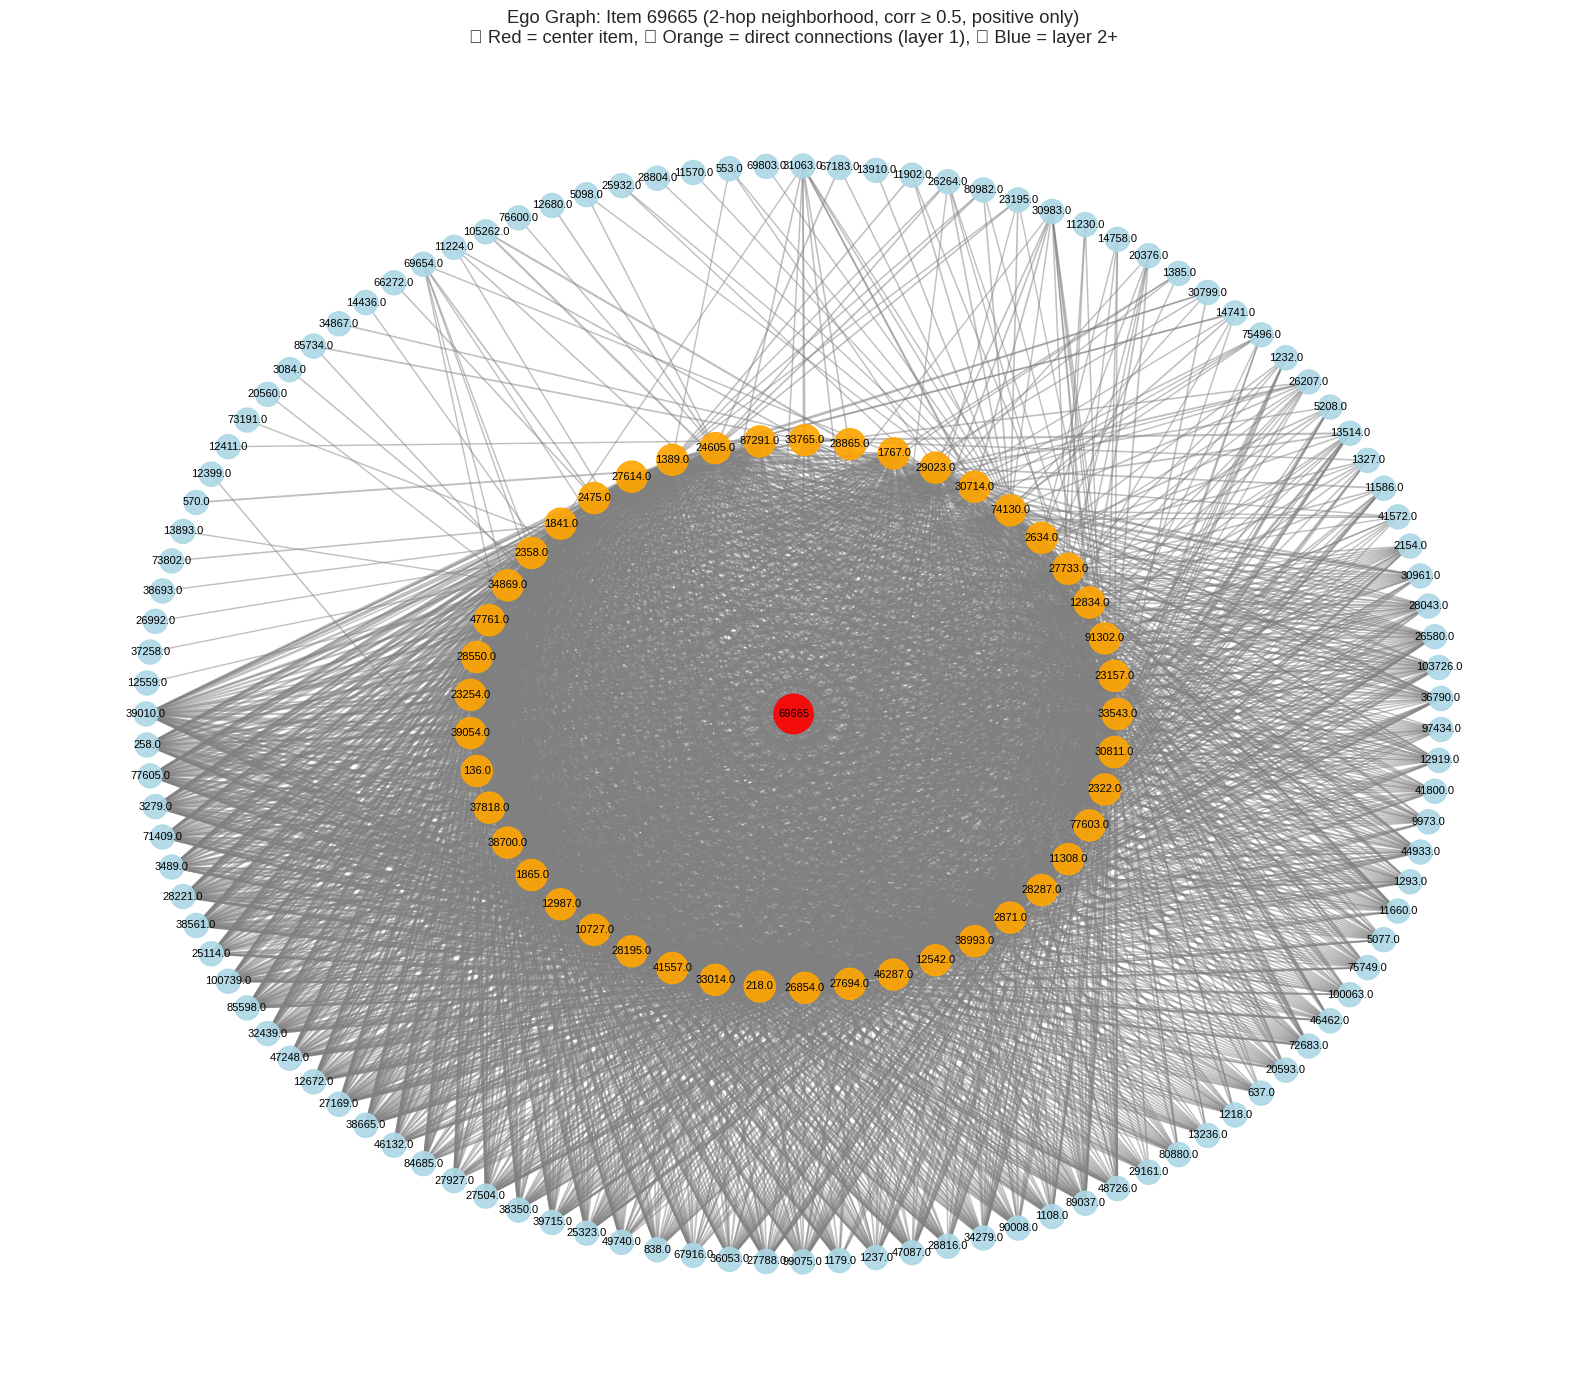


🎯 Center: [69665]
📍 Layer 1 (45 items): [np.float64(27614.0), np.float64(2475.0), np.float64(1841.0), np.float64(2358.0), np.float64(34869.0), np.float64(47761.0), np.float64(28550.0), np.float64(23254.0), np.float64(39054.0), np.float64(136.0), np.float64(37818.0), np.float64(38700.0), np.float64(1865.0), np.float64(12987.0), np.float64(10727.0)]...
📍 Layer 2 (111 items): [np.float64(39010.0), np.float64(258.0), np.float64(77605.0), np.float64(3279.0), np.float64(71409.0), np.float64(3489.0), np.float64(28221.0), np.float64(38561.0), np.float64(25114.0), np.float64(100739.0), np.float64(85598.0), np.float64(32439.0), np.float64(47248.0), np.float64(12672.0), np.float64(27169.0)]...


In [ ]:
# ============================================
# 🎯 EGO GRAPH: Select an item and explore its neighborhood
# ============================================
CENTER_ITEM = 10022  # The item to center the graph on
NUM_LAYERS = 2  # 1 = direct connections only, 2 = friends of friends, etc.
EGO_MIN_CORR = 0.5  # Minimum correlation to show an edge
EGO_POSITIVE_ONLY = True  # Only positive correlations

def build_ego_graph(center_item, pairs_df, num_layers, min_corr, positive_only):
    """Build a graph showing items within N hops of center_item."""
    G = nx.Graph()
    G.add_node(center_item)
    
    # Filter pairs
    if positive_only:
        valid_pairs = pairs_df[pairs_df["corr"] >= min_corr]
    else:
        valid_pairs = pairs_df[pairs_df["abs_corr"] >= min_corr]
    
    # Build lookup for fast neighbor finding
    neighbors = {}
    for _, row in valid_pairs.iterrows():
        a, b, corr = row["item_a"], row["item_b"], row["corr"]
        neighbors.setdefault(a, []).append((b, corr))
        neighbors.setdefault(b, []).append((a, corr))
    
    # BFS to find nodes within num_layers hops
    current_layer = {center_item}
    all_nodes = {center_item}
    node_distances = {center_item: 0}
    
    for layer in range(1, num_layers + 1):
        next_layer = set()
        for node in current_layer:
            for neighbor, corr in neighbors.get(node, []):
                if neighbor not in all_nodes:
                    next_layer.add(neighbor)
                    all_nodes.add(neighbor)
                    node_distances[neighbor] = layer
                # Add edge regardless (might connect nodes in same layer)
                if neighbor in all_nodes:
                    G.add_edge(node, neighbor, corr=corr, weight=abs(corr))
        current_layer = next_layer
    
    return G, node_distances

if HAS_NETWORKX and not pairs_df.empty:
    # Check if center item exists in data
    all_items = set(pairs_df["item_a"].tolist() + pairs_df["item_b"].tolist())
    
    if CENTER_ITEM not in all_items:
        print(f"⚠️ Item {CENTER_ITEM} not found in pairs data.")
        print(f"   Try one of these items: {list(all_items)[:10]}")
    else:
        G_ego, distances = build_ego_graph(CENTER_ITEM, pairs_df, NUM_LAYERS, EGO_MIN_CORR, EGO_POSITIVE_ONLY)
        
        print(f"Ego graph for item {CENTER_ITEM}:")
        print(f"   {G_ego.number_of_nodes()} nodes, {G_ego.number_of_edges()} edges")
        print(f"   Layers: {NUM_LAYERS}, Min correlation: {EGO_MIN_CORR}")
        
        if G_ego.number_of_nodes() > 1:
            fig, ax = plt.subplots(figsize=(16, 14))
            
            # Use shell layout - center item in middle, layers as concentric rings
            shells = []
            for layer in range(NUM_LAYERS + 1):
                layer_nodes = [n for n, d in distances.items() if d == layer]
                if layer_nodes:
                    shells.append(layer_nodes)
            
            if len(shells) > 1:
                pos = nx.shell_layout(G_ego, nlist=shells)
            else:
                pos = nx.spring_layout(G_ego, k=2, seed=42)
            
            # Color nodes by distance from center
            max_dist = max(distances.values()) if distances else 0
            node_colors = []
            node_sizes = []
            for node in G_ego.nodes():
                dist = distances.get(node, 0)
                if node == CENTER_ITEM:
                    node_colors.append("red")
                    node_sizes.append(800)
                elif dist == 1:
                    node_colors.append("orange")
                    node_sizes.append(500)
                else:
                    node_colors.append("lightblue")
                    node_sizes.append(300)
            
            # Draw edges
            edges = G_ego.edges(data=True)
            edge_weights = [d.get("weight", 0.5) * 2 for _, _, d in edges]
            edge_colors = ["red" if d.get("corr", 0) < 0 else "gray" for _, _, d in edges]
            nx.draw_networkx_edges(G_ego, pos, alpha=0.5, width=edge_weights, 
                                   edge_color=edge_colors, ax=ax)
            
            # Draw nodes
            nx.draw_networkx_nodes(G_ego, pos, node_color=node_colors, 
                                   node_size=node_sizes, alpha=0.9, ax=ax)
            
            # Draw labels
            nx.draw_networkx_labels(G_ego, pos, font_size=8, ax=ax)
            
            corr_type = "positive only" if EGO_POSITIVE_ONLY else "all"
            ax.set_title(f"Ego Graph: Item {CENTER_ITEM} ({NUM_LAYERS}-hop neighborhood, corr ≥ {EGO_MIN_CORR}, {corr_type})\n"
                        f"🔴 Red = center item, 🟠 Orange = direct connections (layer 1), 🔵 Blue = layer 2+")
            ax.axis("off")
            plt.tight_layout()
            plt.show()
            
            # Show layer breakdown
            for layer in range(NUM_LAYERS + 1):
                layer_nodes = [n for n, d in distances.items() if d == layer]
                if layer == 0:
                    print(f"\n🎯 Center: {layer_nodes}")
                else:
                    print(f"📍 Layer {layer} ({len(layer_nodes)} items): {layer_nodes[:15]}{'...' if len(layer_nodes) > 15 else ''}")
        else:
            print(f"⚠️ No connections found for item {CENTER_ITEM} with corr ≥ {EGO_MIN_CORR}")


## 9. Quick Reference: Find Items

Search for specific items or find what cluster an item belongs to.


In [50]:
def find_item_cluster(item_id: int) -> None:
    """Find which cluster an item belongs to."""
    if clusters_df.empty:
        print("No cluster data loaded")
        return
    
    match = clusters_df[clusters_df["item_id"] == item_id]
    if match.empty:
        print(f"Item {item_id} not found in clusters")
        return
    
    row = match.iloc[0]
    cluster_id = row["cluster_id"]
    cluster_size = row["cluster_size"]
    
    # Get other items in same cluster
    cluster_members = clusters_df[clusters_df["cluster_id"] == cluster_id]["item_id"].tolist()
    
    print(f"📍 Item {item_id}:")
    print(f"   Cluster ID: {cluster_id}")
    print(f"   Cluster size: {cluster_size} items")
    print(f"   Other items in cluster: {[x for x in cluster_members if x != item_id][:10]}")


def find_correlated_pairs(item_id: int, min_corr: float = 0.5) -> pd.DataFrame:
    """Find all pairs involving a specific item."""
    if pairs_df.empty:
        return pd.DataFrame()
    
    mask = (pairs_df["item_a"] == item_id) | (pairs_df["item_b"] == item_id)
    matches = pairs_df[mask & (pairs_df["abs_corr"] >= min_corr)]
    return matches.sort_values("abs_corr", ascending=False)


# Example usage:
print("🔍 Example: Find cluster for item 10022")
find_item_cluster(10022)


🔍 Example: Find cluster for item 10022
Item 10022 not found in clusters


In [33]:
# Find all items correlated with a specific item
print("🔍 Example: Find pairs correlated with item 10022")
correlated = find_correlated_pairs(10022, min_corr=0.5)
display(correlated.head(15))


🔍 Example: Find pairs correlated with item 10022


Empty DataFrame
Columns: [item_a, item_b, corr, pair_count, abs_corr]
Index: []

---

## 💡 Tips

1. **Re-run the correlation script** with different parameters:
   ```bash
   # More items, lower threshold for more clusters
   uv run python scripts/compute_price_correlations.py --temporal-only --sample-items 1000 --threshold 0.5
   
   # All items (takes a while)
   uv run python scripts/compute_price_correlations.py --temporal-only --threshold 0.6
   ```

2. **Interpretation**:
   - **Positive correlation (0.7+)**: Prices move together - same market forces
   - **Negative correlation (-0.7 or less)**: Prices move opposite - substitutes or arbitrage
   - **Near zero**: No relationship

3. **Files generated**:
   - `clusters_temporal.csv` - All items with their cluster assignment
   - `top_pairs_temporal.csv` - Top correlated pairs with correlation values
